In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
import seaborn as sns
from statsmodels.stats.anova import AnovaRM

import h5py

from tqdm import tqdm

In [2]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [3]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import stat as sstat

In [4]:
import warnings

---

In [5]:
mpl.rcParams['font.family'] = 'Helvetica'

## Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [6]:
dir_behav = su.get_dir_behav()

---

In [7]:
list_sn = su.get_list_sn()
list_sn

array(['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13',
       '14'], dtype='<U2')

---

## sessions
- ses-1 (S)
- ses-2 (R)

Each session is consist of 8 runs with 68 trials (4 blocks, 17 trials for each block), additional run with long-ISI.
1. The starting trial states are randomly permuted.
2. 5s for each trial (preparation: 1s, movement: 3s, ISI: 1s)
3. Long resting period between blocks (~16 seconds)
4. Each run takes about 7 minutes
5. 17-, 34-, 57-, 64-th trial's ITI are $16000$

## motor sequences
- 32451
- 35124
- 13254
- 14523
## visual cues
- letter
- spatial

---

### (point, isError)
1) (0,0): MT=0 but the response is correct up to that point.
2) (0,1): At some point, the response becomes incorrect.
3) (1,0): A properly conducted trial.

PrepTime(1s) + press(3s) + ITI(1s) = 5s
- $\text{MT} \neq pressTime4 - pressTime0$
- $\text{RT} = pressTime0 - 1000(PrepTime) - (4\text{ or }6)$

## 1. Repetition

 | | symbol | trial$_{t-1}$ | trial $_{t}$ |
 |---------|---------|---------|---------|
 | Both-Rep$_{c}$ <br> (within-$c$ repetition) | <span style="color:#00008B">$B_{c}$</span> | $(s,c)$ | $(s,c)$ |
 | Cue-Rep$_{c}$ <br> (within-$c$ no-repetition) | <span style="color:#0000FF">$C_{c}$</span> | $(\neg s,c)$ | $(s,c)$ |
 | Seq-Rep$_{c}$ <br> (between-$c$ repetition) | <span style="color:#8B0000">$S_{c}$</span> | $(s,\neg c)$ | $(s,c)$ |
 | Non-Rep$_{c}$ <br> (between-$c$ no-repetition) | <span style="color:#FF0000">$N_{c}$</span> | $(\neg s,\neg c)$ | $(s,c)$ |

$Trial State=(s,c)$:\
$ s=0: 32451 $, $ s=1: 35124 $, $s=2: 13254 $, $s=3: 14523$ \
$ c=0: Letter $, $ c=1: Spatial $

In [8]:
dg = pd.DataFrame()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for sess in ['S','R']:
        for sn in tqdm(list_sn):
            subj = sess+sn
            fname = join(dir_behav,'sub-%s/behav_info.tsv'%subj)
            df = pd.read_csv(fname, delimiter='\t')
            df_tmp = df.copy()
    
            df_tmp['ITI-1'] = df.ITI.shift(1)
            df_tmp['cue-1'] = df.cue.shift(1)
            df_tmp['sequence-1'] = df.sequence.shift(1)
            df_tmp['RT-1'] = df.RT.shift(1)
            df_tmp['MT-1'] = df.MT.shift(1)
            
            ## 1 <= TN <= 64
            df = df_tmp[(df_tmp.TN>1)&(df_tmp.TN<=64)].copy()
            ## ITI-1 <= 1000 ms
            df = df[df['ITI-1']<=1000]
            # df = df[df['isError']==0]
            ## long term trials have no previous trial
            # df_tmp[df_tmp.TN%17==1]['MT-1']=np.nan
            # df_tmp[df_tmp.TN%17==1]['RT-1']=np.nan
    
            df['ITI-1'] = df['ITI-1'].astype(int)
            # df['cue-1'] = df['cue-1'].astype(int)
            df['sequence-1'] = df['sequence-1'].astype(int)
            df['RT-1'] = df['RT-1'].astype(int)
            df['MT-1'] = df['MT-1'].astype(int)
            
            ## default condition = NRep
            df['cond'] = 'Non-Rep'
            ## other conditions
            df.loc[(df.cue==df['cue-1'])&(df.sequence==df['sequence-1']),'cond'] = 'Both-Rep'
            df.loc[(df.cue==df['cue-1'])&(df.sequence!=df['sequence-1']),'cond'] = 'Cue-Rep'
            df.loc[(df.cue!=df['cue-1'])&(df.sequence==df['sequence-1']),'cond'] = 'Seq-Rep'
            ## subj label
            df['sess']=sess
            df['subj']=sn
            df['x'] = ['%s_%s'%(cue,sess) for cue,sess in zip(df['cue'], df['sess'])]
            ## 수행한 total trial number
            df['trial']=(df.BN-1)*64+df.TN
            ## remove unncessary rows
            df = df[df.TN%17 != 1]

            dg = pd.concat([dg,df])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.52it/s]


In [9]:
dg['cond'] = dg.cond.replace({
    'Both-Rep':'Within Rep', 'Cue-Rep':'Within No-Rep',
    'Seq-Rep':'Between Rep', 'Non-Rep':'Between No-Rep'
})
dg

,BN,TN,onset,prepTime,cue,sequence,MT,RT,isError,ITI,...,ITI-1,cue-1,sequence-1,RT-1,MT-1,cond,sess,subj,x,trial
1,1,2,13030,1000,S,4,1720,382,0,1000,...,1000,S,2,566,1680,Within No-Rep,S,01,S_S,2
2,1,3,18030,1000,L,4,2056,438,0,1000,...,1000,S,4,382,1720,Between Rep,S,01,L_S,3
3,1,4,23030,1000,L,2,1528,478,0,1000,...,1000,L,4,438,2056,Within No-Rep,S,01,L_S,4
4,1,5,28030,1000,S,1,1308,408,0,1000,...,1000,L,2,478,1528,Between No-Rep,S,01,S_S,5
5,1,6,33030,1000,L,2,1776,446,0,1000,...,1000,S,1,408,1308,Between No-Rep,S,01,L_S,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,8,60,348020,1000,L,3,1060,322,0,1000,...,1000,S,3,374,1038,Between Rep,R,14,L_R,508
536,8,61,353020,1000,S,2,1042,308,0,1000,...,1000,L,3,322,1060,Between No-Rep,R,14,S_R,509
537,8,62,358020,1000,L,2,1172,312,0,1000,...,1000,S,2,308,1042,Between Rep,R,14,L_R,510
538,8,63,363020,1000,L,4,1010,348,0,1000,...,1000,L,2,312,1172,Within No-Rep,R,14,L_R,511


---

### 학습이 일어났는가?

In [52]:
dg.columns

Index(['BN', 'TN', 'onset', 'prepTime', 'cue', 'sequence', 'MT', 'RT',
       'isError', 'ITI', 'response', 'ITI-1', 'cue-1', 'sequence-1', 'RT-1',
       'MT-1', 'cond', 'sess', 'subj', 'x', 'trial'],
      dtype='object')

In [53]:
## invalid trial들은 제거 후 Block마다 within subject 평균
dh = dg[dg.isError==0].groupby(['sess','subj','BN'])[['MT','RT']].median().reset_index()
dh

,sess,subj,BN,MT,RT
0,R,01,1,1562.0,374.0
1,R,01,2,1334.0,328.0
2,R,01,3,1394.0,330.0
3,R,01,4,1398.0,331.0
4,R,01,5,1416.0,364.0
...,...,...,...,...,...
187,S,14,4,969.0,323.0
188,S,14,5,896.0,329.0
189,S,14,6,938.0,348.0
190,S,14,7,952.0,354.0


MT
S t(11)=1.7298 (ns)
R t(11)=2.0562 (ns)
RT
S t(11)=0.5832 (ns)
R t(11)=0.7926 (ns)


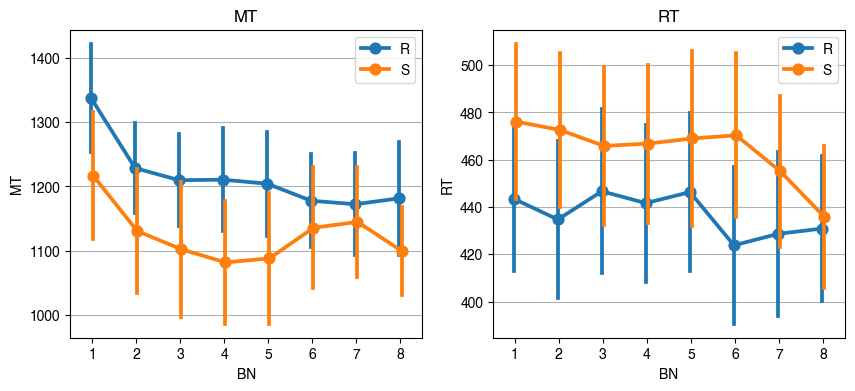

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

for ii, value in enumerate(['MT','RT']):
    print(value)
    ax = axs[ii]
    g = sns.pointplot(
        data=dh,
        x='BN', y=value, hue='sess',
        estimator='mean',
        errorbar='se', dodge=True,
        ax=ax
    )
    g.set_title(value)
    g.legend()
    g.grid(axis='y')

    for sess in ['S','R']:
        tmp = dh[(dh.sess==sess)].set_index('subj', drop=False)
        a = tmp[tmp.BN==1][value].astype(float)
        b = tmp[tmp.BN==2][value].astype(float)
        res = scipy.stats.ttest_rel(a=a, b=b, alternative='two-sided')
        print(sess, 't(%d)=%.4f (%s)'%(res.df, res.statistic, sstat.convert_pval_to_star(res.pvalue)))

---

In [25]:
## invalid trial들은 제거 후 within subject 평균
tmp = dg[dg.isError==0].groupby(['subj','sess','cue','cond'])[['isError','MT','RT']].median().reset_index()

dg_groupby = tmp[tmp.sess=='S']
dg_groupby

,subj,sess,cue,cond,isError,MT,RT
8,01,S,L,Between No-Rep,0.0,1810.0,398.0
9,01,S,L,Between Rep,0.0,1868.0,414.0
10,01,S,L,Within No-Rep,0.0,1798.0,402.0
11,01,S,L,Within Rep,0.0,1754.0,400.0
12,01,S,S,Between No-Rep,0.0,1830.0,402.0
...,...,...,...,...,...,...,...
187,14,S,L,Within Rep,0.0,956.0,340.0
188,14,S,S,Between No-Rep,0.0,953.0,328.0
189,14,S,S,Between Rep,0.0,974.0,326.0
190,14,S,S,Within No-Rep,0.0,952.0,330.0


In [26]:
hue_order = ['Within Rep','Within No-Rep','','Between Rep','Between No-Rep']
order = ['L','S']
palette = ['#191970','#89CFF0','#FFFFFF','#800020','#F08080']
# palette = ['#191970','#800020']

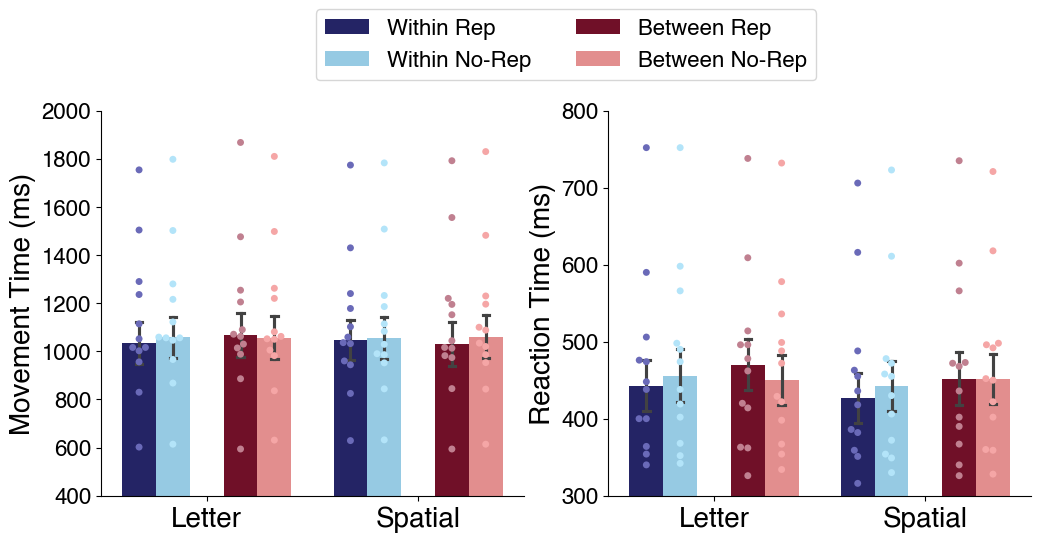

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

for ii, feature in enumerate(['MT','RT']):
    ax = axs[ii]
    g = sns.barplot(
        data=dg_groupby,
        x='cue', order=order,
        y=feature, estimator='median',
        hue='cond', hue_order=hue_order,
        errorbar='se', capsize=0.15,
        width=0.8,
        palette=palette,
        ax=ax
    )
    g = sns.swarmplot(
        data=dg_groupby,
        x='cue', order=order,
        y=feature,
        hue='cond', hue_order=hue_order, dodge=True,
        edgecolor='black',
        palette=['#6A6AB8','#B3E4F9','#FFFFFF','#C08090','#F5A6A6'],
        ax=ax
    )
    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()
    
    # g.grid(axis='y')
    if ii == 0:
        ylabel = 'Movement Time (ms)'
        g.set_ylim(500,2000)
        g.legend(
            handles[:4], labels[:4],
            loc='lower center', bbox_to_anchor=(1.1, 1.05),
            ncol=2, fontsize=16
        )
    elif ii == 1:
        ylabel = 'Reaction Time (ms)'
        g.set_ylim(300,800)

    g.set_xlabel('')
    # g.set_xlabel('Letter%sSpatial'%''.ljust(30), fontsize=14)
    g.set_xticks([0,1])
    g.set_xticklabels(['Letter','Spatial'], fontsize=20)
    yticks = g.get_yticks().astype(int)
    g.set_ylabel(ylabel,fontsize=20)
    g.set_yticks(yticks)
    g.set_yticklabels(yticks, fontsize=16)
    # g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
    # g.set_title('session %s'%sess,fontsize=16)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
        
# fig.tight_layout()

## ANOVA

In [28]:
for value in ['MT','RT']:
    print(value)
    aov = AnovaRM(
        data=dg_groupby,
        depvar=value,
        subject='subj',
        within=['cue','cond']
    ).fit()
    print(aov)

MT
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
cue       4.9268 1.0000 11.0000 0.0484
cond      2.2809 3.0000 33.0000 0.0975
cue:cond  0.2203 3.0000 33.0000 0.8816

RT
                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
cue       5.9796 1.0000 11.0000 0.0325
cond      5.3925 3.0000 33.0000 0.0039
cue:cond  1.6238 3.0000 33.0000 0.2026



## paired t-test (Letter vs. Spatial)

### Repetition advantage

In [37]:
ds = dg[dg.isError==0].groupby(['sess','subj','cue','cond'])[['MT','RT']].mean().reset_index()
ds = ds[ds.sess=='S'].set_index('subj', drop=False)
ds

,sess,subj,cue,cond,MT,RT
subj,,,,,,
01,S,01,L,Between No-Rep,1822.735632,414.459770
01,S,01,L,Between Rep,1767.931034,475.517241
01,S,01,L,Within No-Rep,1782.674699,424.337349
01,S,01,L,Within Rep,1732.400000,431.466667
01,S,01,S,Between No-Rep,1807.126437,409.379310
...,...,...,...,...,...,...
14,S,14,L,Within Rep,968.064516,383.161290
14,S,14,S,Between No-Rep,955.372093,334.395349
14,S,14,S,Between Rep,957.655172,330.965517


In [38]:
for value in ['MT','RT']:
    print(value)
    for cue in ['L', 'S']:
        print(cue)
        for co in ['Within','Between']:
            print(co)
            a = ds[(ds.cue==cue)&(ds.cond==co+' Rep')][value].astype(float)
            b = ds[(ds.cue==cue)&(ds.cond==co+' No-Rep')][value].astype(float)
            res = scipy.stats.ttest_rel(a=a, b=b, alternative='two-sided')
            pval = res.pvalue
            print('paired: t(%d)=%.4f, p=%.4f (%s)'%(res.df, res.statistic, pval, sstat.convert_pval_to_star(pval)))

MT
L
Within
paired: t(11)=-0.8058, p=0.4374 (ns)
Between
paired: t(11)=0.3149, p=0.7588 (ns)
S
Within
paired: t(11)=-0.0288, p=0.9776 (ns)
Between
paired: t(11)=-0.3418, p=0.7389 (ns)
RT
L
Within
paired: t(11)=-0.9585, p=0.3584 (ns)
Between
paired: t(11)=1.3320, p=0.2098 (ns)
S
Within
paired: t(11)=-0.9747, p=0.3506 (ns)
Between
paired: t(11)=-0.4148, p=0.6862 (ns)


### Overall comparison

In [39]:
ds = dg[dg.isError==0].groupby(['sess','subj','cue'])[['MT','RT']].mean().reset_index()
ds = ds[ds.sess=='S'].set_index('subj', drop=False)
ds

,sess,subj,cue,MT,RT
subj,,,,,
01,S,01,L,1789.441048,428.000000
01,S,01,S,1805.234234,394.477477
02,S,02,L,1037.741667,380.908333
02,S,02,S,1020.228814,367.550847
03,S,03,L,1031.206897,427.284483
03,S,03,S,1041.206751,450.919831
05,S,05,L,1077.367089,430.497890
05,S,05,S,1101.630901,420.403433
06,S,06,L,1059.059322,741.677966


MT
paired: t(11)=2.0573, p=0.0642 (ns)
RT
paired: t(11)=2.4337, p=0.0332 (*)


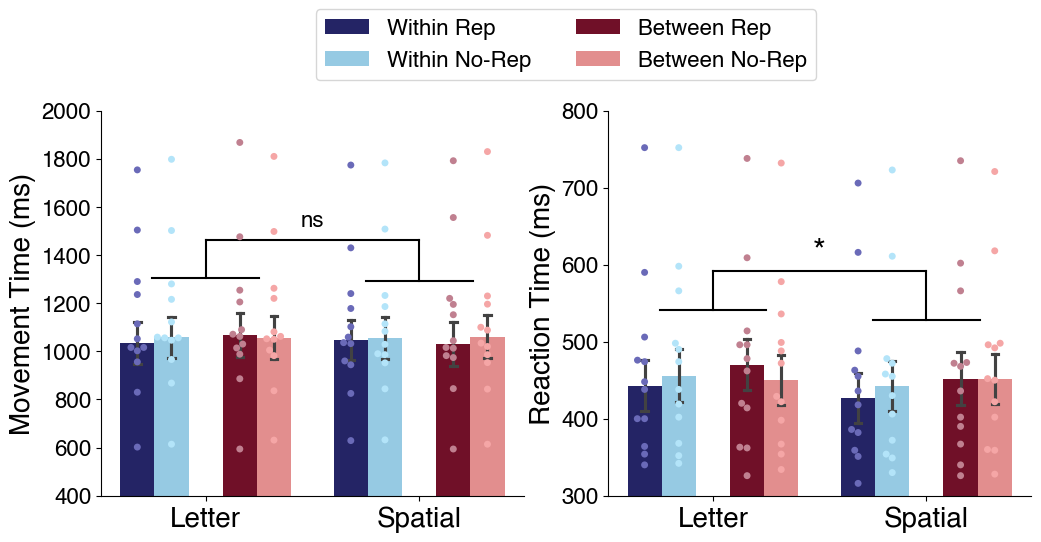

In [40]:
color = 'black'
for ii, value in enumerate(['MT','RT']):
    ax = axs[ii]
    
    ylim = np.array(ax.get_ylim())
    ydiff = np.diff(ylim)[0]
    ymean = ylim.mean()
    dy = ydiff * 0.05
    # ax.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])

    print(value)
    a = ds[ds.cue=='L'][value].astype(float)
    b = ds[ds.cue=='S'][value].astype(float)
    res = scipy.stats.ttest_rel(a=a, b=b, alternative='two-sided')
    pval = res.pvalue
    print('paired: t(%d)=%.4f, p=%.4f (%s)'%(res.df, res.statistic, pval, sstat.convert_pval_to_star(pval)))
    
    x1 = 0
    y1 = a.mean() + a.sem() + dy*1
    ax.plot([x1-0.25,x1+0.25],[y1,y1],linestyle='-',color=color)
    x2 = 1
    y2 = b.mean() + b.sem() + dy*1
    ax.plot([x2-0.25,x2+0.25],[y2,y2],linestyle='-',color=color)
    yU = max(y1,y2) + dy*2
    ax.plot([x1,x1],[y1,yU],linestyle='-',color=color)
    ax.plot([x2,x2],[y2,yU],linestyle='-',color=color)
    ax.plot([x1,x2],[yU,yU],linestyle='-',color=color)
    if pval>=0.05:
        fontsize=16
    else:
        fontsize=24
    ax.text(
        (x1+x2)*0.5, yU+dy,
        sstat.convert_pval_to_star(pval), fontsize=fontsize, color=color,
        ha='center', va='center'
    )
fig

-> 두 Cue의 Overall performance 는 paired t-test 를 했을때 RT 에서 그룹간(cue) 차이가 확인됐다. 즉, 피험자들은 spatial에서 더 빠르게 시퀀스를 입력할 수 있다. 다만 MT 에서는 그러한 효과가 발견되지 않았다.

---
---

### 어떤 Seq가 어려웠나?

In [89]:
sess = 'S'

In [90]:
df = pd.DataFrame()
for sn in list_sn:
    subj = sess+sn
    fname = join(dir_behav,'sub-%s/ssh__%s.dat'%(subj,subj))
    df_tmp = pd.read_csv(fname, delimiter='\t')
    df_tmp = df_tmp[['BN','TN','seqType','cueP','MT','RT','points','isError']]
    
    ## 각 run의 가장 마지막 trial은 제외
    # df = df[df.iti<2000]

    ## 9번째 run (long ITI)은 제거
    df_tmp = df_tmp[df_tmp.BN < 9]

    ## 성공적으로 수행한 trial들만 고려
    # df_tmp = df_tmp[df_tmp.points == 1]
    df_tmp = df_tmp[df_tmp.isError == 0]

    df_tmp.seqType = ['Letter' if i==0 else 'Spatial' for i in df_tmp.seqType]
    df_tmp.cueP = df_tmp.cueP.astype('str')

    df_tmp['subj'] = subj
    # df_tmp['hue'] = ['%s_%s'%(seq,ses) for seq,ses in zip(df_tmp.seqType,df_tmp.sess)]

    df = pd.concat([df,df_tmp])

df.rename(columns={'seqType':'cue', 'cueP':'seq'}, inplace=True)
df['cue'] = df.cue.replace({'Letter':'L', 'Spatial':'S'})
df

,BN,TN,cue,seq,MT,RT,points,isError,subj
0,1,1,S,35124,1680,566,1,0,S01
1,1,2,S,14523,1720,382,1,0,S01
2,1,3,L,14523,2056,438,1,0,S01
3,1,4,L,35124,1528,478,1,0,S01
4,1,5,S,32451,1308,408,1,0,S01
...,...,...,...,...,...,...,...,...,...
539,8,64,S,32451,796,436,1,0,S14
540,8,65,L,32451,790,404,1,0,S14
541,8,66,S,32451,832,246,1,0,S14
542,8,67,L,14523,816,400,1,0,S14


In [91]:
df_groupby = df.groupby(['subj','cue','seq'])[['MT','RT']].mean().reset_index()
df_groupby

,subj,cue,seq,MT,RT
0,S01,L,13254,1740.716418,435.940299
1,S01,L,14523,1927.096774,410.451613
2,S01,L,32451,1756.062500,438.656250
3,S01,L,35124,1728.212121,440.303030
4,S01,S,13254,1668.707692,407.138462
...,...,...,...,...,...
91,S14,L,35124,938.656716,368.358209
92,S14,S,13254,937.384615,349.384615
93,S14,S,14523,958.477612,337.910448
94,S14,S,32451,974.176471,320.911765


In [92]:
list_seq = ['32451','35124','13254','14523']

MT
32451
t(11)=2.1735, nsp=0.0525
35124
t(11)=0.1990, nsp=0.8459
13254
t(11)=1.6369, nsp=0.1299
14523
t(11)=0.4050, nsp=0.6932
RT
32451
t(11)=5.7743, ***p=0.0001
35124
t(11)=3.3537, **p=0.0064
13254
t(11)=0.9114, nsp=0.3816
14523
t(11)=0.5741, nsp=0.5774


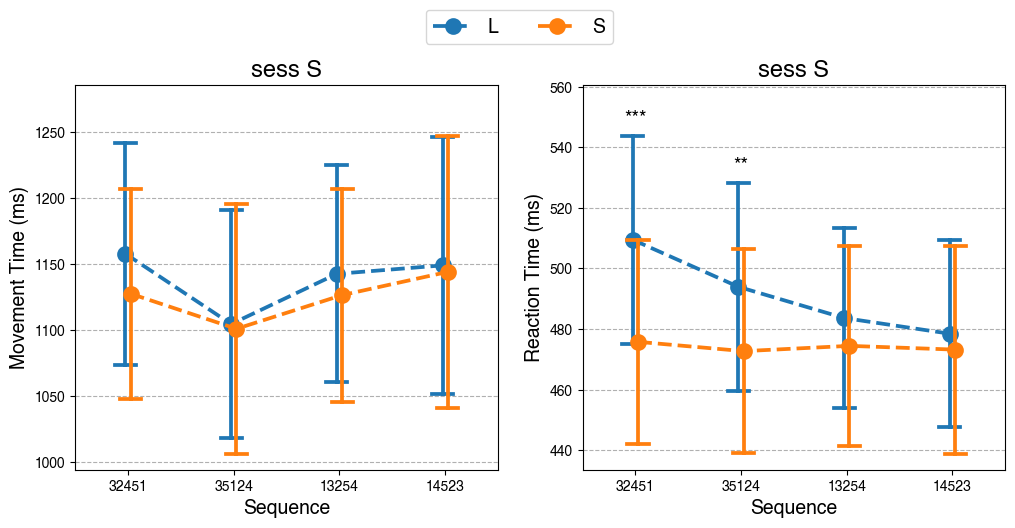

In [93]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))

hue = 'cue'
# hue = 'sess'
for ii, feature in enumerate(['MT','RT']):
    print(feature)
    ax = axs[ii]
    g = sns.pointplot(
        data=df_groupby,
        x='seq', order=list_seq, y=feature, hue=hue,
        linestyles='--', markers=['o','o'], markersize=10,
        errorbar='se', capsize=0.2, dodge=True,
        ax=ax
    )
    g.grid(axis='y', linestyle='--')
    if ii==0:
        g.legend(loc='center', bbox_to_anchor=(1.05, 1.15), ncol=2, fontsize=14)
    else:
        g.legend().remove()
    g.set_xlabel('Sequence', fontsize=14)
    ylabel = 'Movement Time (ms)' if feature=='MT' else 'Reaction Time (ms)'
    g.set_ylabel(ylabel, fontsize=14)
    g.set_title('sess %s'%sess, fontsize=17)
    ya, yb = g.get_ylim()
    dy = (yb-ya) * 0.05

    ## t-test
    for ss, seq in enumerate(list_seq):
        print(seq)
        a = df_groupby[(df_groupby.cue=='L')&(df_groupby.seq==seq)][feature].astype(float)
        b = df_groupby[(df_groupby.cue=='S')&(df_groupby.seq==seq)][feature].astype(float)
        res = scipy.stats.ttest_rel(a,b)
        tval, pval = res
        dof = res.df
        print('t(%d)=%.4f, %sp=%.4f'%(dof,tval,sstat.convert_pval_to_star(pval),pval))
        
        if pval < 0.05:
            x = ss # + 0.2*(cc-1.5)
            y1 = a.mean()+a.sem()
            y2 = b.mean()+b.sem()
            y = max(y1,y2) + dy
            
            g.text(
                x, y,
                sstat.convert_pval_to_star(pval), fontsize=14, color='black',
                ha='center', va='center',
            )
    g.set_ylim(ya,yb+dy*2)

-> Spatial Cue의 경우 직관적이므로, 반응시간(RT)과 입력시간(MT) 모두 단축되었으며, sequence에 관계없이 비슷한 시간들을 나타낸다.

-> 첫 손가락이 '3'인 경우 입력 속도가 느림 (RT$\uparrow$)

---
---

Repeptition Advance 가 있는가?

In [34]:
## invalid trial들은 제거 후 within subject 평균
dg_groupby = dg[dg.isError==0].groupby(['sess','subj','cue','cond','x'])[['isError','MT','RT','MT-1','RT-1']].median().reset_index()
dg_groupby['cond'] = dg_groupby.cond.replace({
    'Both-Rep':'Within Rep', 'Cue-Rep':'Within No-Rep',
    'Seq-Rep':'Between Rep', 'Non-Rep':'Between No-Rep'
})
dg_groupby

,sess,subj,cue,cond,x,isError,MT,RT,MT-1,RT-1
0,R,01,L,Within Rep,L_R,0.0,1486.0,348.0,1501.0,373.0
1,R,01,L,Within No-Rep,L_R,0.0,1502.0,358.0,1506.0,356.0
2,R,01,L,Between No-Rep,L_R,0.0,1500.0,341.0,1399.0,333.0
3,R,01,L,Between Rep,L_R,0.0,1444.0,364.0,1386.0,332.0
4,R,01,S,Within Rep,S_R,0.0,1358.0,330.0,1398.0,317.0
...,...,...,...,...,...,...,...,...,...,...
187,S,14,L,Between Rep,L_S,0.0,988.0,326.0,926.0,342.0
188,S,14,S,Within Rep,S_S,0.0,960.0,316.0,965.0,318.0
189,S,14,S,Within No-Rep,S_S,0.0,952.0,330.0,962.0,328.0
190,S,14,S,Between No-Rep,S_S,0.0,953.0,328.0,972.0,346.0


In [35]:
hue_order = ['Within Rep','Within No-Rep','','Between Rep','Between No-Rep']
palette = ['#191970','#89CFF0','#FFFFFF','#800020','#F08080']

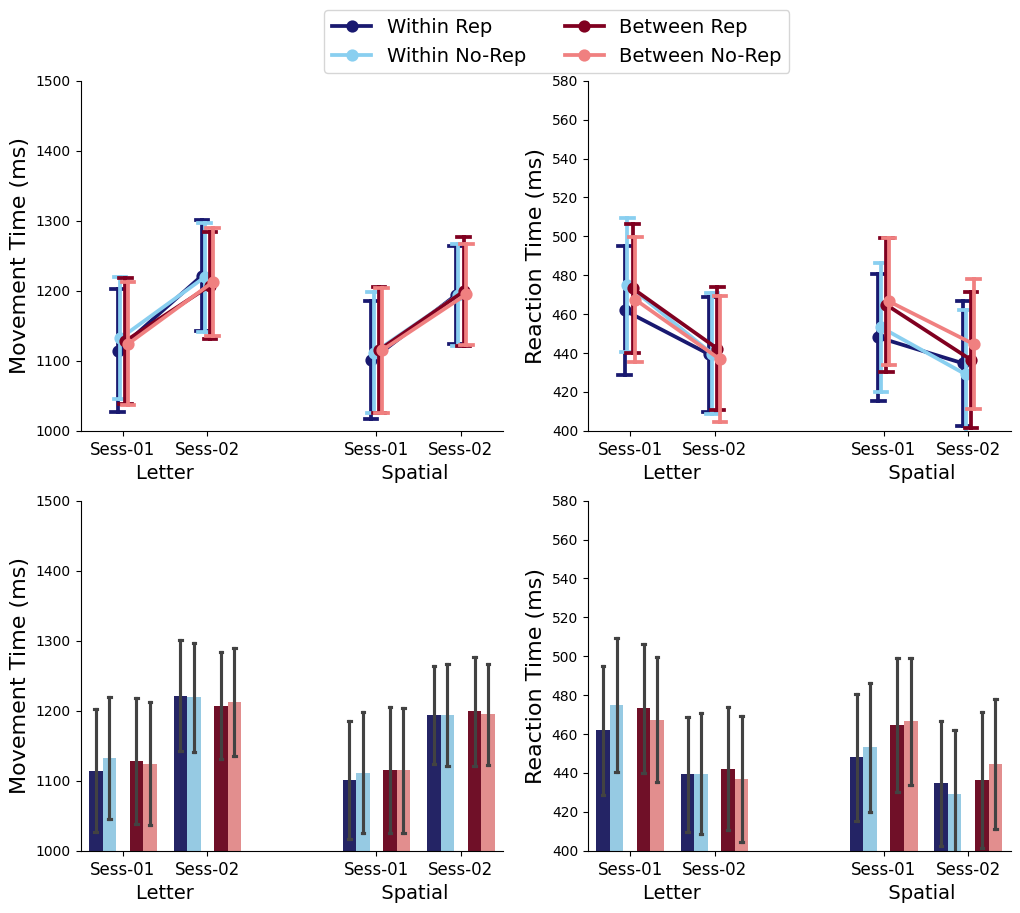

In [36]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,10))

for aa in range(2):
    for ii, feature in enumerate(['MT','RT']):
        ax = axs[aa,ii]
        if aa == 0:
            g = sns.pointplot(
                data=dg_groupby,
                x='x', order=['L_S','L_R','','S_S','S_R'],
                y=feature, estimator='mean',
                hue='cond', hue_order=hue_order,
                capsize=0.15, errorbar='se', dodge=True,
                palette=palette,
                ax=ax
            )
        else:
            g = sns.barplot(
                data=dg_groupby,
                x='x', order=['L_S','L_R','','S_S','S_R'],
                y=feature, estimator='mean',
                hue='cond', hue_order=hue_order,
                capsize=0.15, errorbar='se',
                palette=palette,
                ax=ax
            )
        # g.legend()
        g.legend().remove()
        # g.grid(axis='y')
        if ii == 0:
            g.set_ylabel('Movement Time (ms)',fontsize=16)
            g.set_ylim(1000,1500)
        elif ii == 1:
            g.set_ylabel('Reaction Time (ms)',fontsize=16)
            g.set_ylim(400,580)
            if aa == 0:
                g.legend(loc='best', bbox_to_anchor=(0.50, 1.23), ncol=2, fontsize=14)
        g.set_xlabel('Letter%sSpatial'%''.ljust(30), fontsize=14)
        g.set_xticks([0,1,3,4])
        g.set_xticklabels(['Sess-01','Sess-02','Sess-01','Sess-02'], fontsize=12)
        # g.set_xticklabels(['Letter$_{S}$','Spatial$_{S}$','Letter$_{R}$','Spatial$_{R}$'],fontsize=14)
        # g.set_title('session %s'%sess,fontsize=16)
        g.spines['right'].set_visible(False)
        g.spines['top'].set_visible(False)
        
# fig.tight_layout()

---

## ANOVA

In [13]:
for value in ['MT','RT']:
    print(value)
    aov = AnovaRM(
        data=dg_groupby,
        depvar=value,
        subject='subj',
        within=['sess','cue','cond']
    ).fit()
    print(aov)

MT
                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
sess           2.0992 1.0000 11.0000 0.1753
cue            8.1840 1.0000 11.0000 0.0155
cond           0.8233 3.0000 33.0000 0.4904
sess:cue       0.4198 1.0000 11.0000 0.5303
sess:cond      1.5963 3.0000 33.0000 0.2089
cue:cond       0.8923 3.0000 33.0000 0.4554
sess:cue:cond  0.4063 3.0000 33.0000 0.7494

RT
                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
sess           3.0127 1.0000 11.0000 0.1105
cue            4.3299 1.0000 11.0000 0.0616
cond           3.2562 3.0000 33.0000 0.0338
sess:cue       3.3931 1.0000 11.0000 0.0926
sess:cond      2.4088 3.0000 33.0000 0.0846
cue:cond       3.6685 3.0000 33.0000 0.0219
sess:cue:cond  0.2769 3.0000 33.0000 0.8417



## paired t-test

#### i) Comparing different cues

In [16]:
tmp = dg[dg.isError==0].groupby(['subj','cue'])[['MT','RT']].mean().reset_index()
tmp

,subj,cue,MT,RT
0,01,L,1643.446623,398.605664
1,01,S,1607.331849,362.770601
2,02,L,1146.509395,378.141962
3,02,S,1113.703390,360.326271
4,03,L,1135.376344,415.569892
5,03,S,1127.397895,439.141053
6,05,L,1206.680672,426.352941
7,05,S,1208.525424,427.258475
8,06,L,1187.530655,708.646934
9,06,S,1178.473573,702.837209


MT: t(11)=4.9442 (***)
RT: t(11)=1.7852 (ns)
MT: t(11)=4.9442 (***)
RT: t(11)=1.7852 (ns)


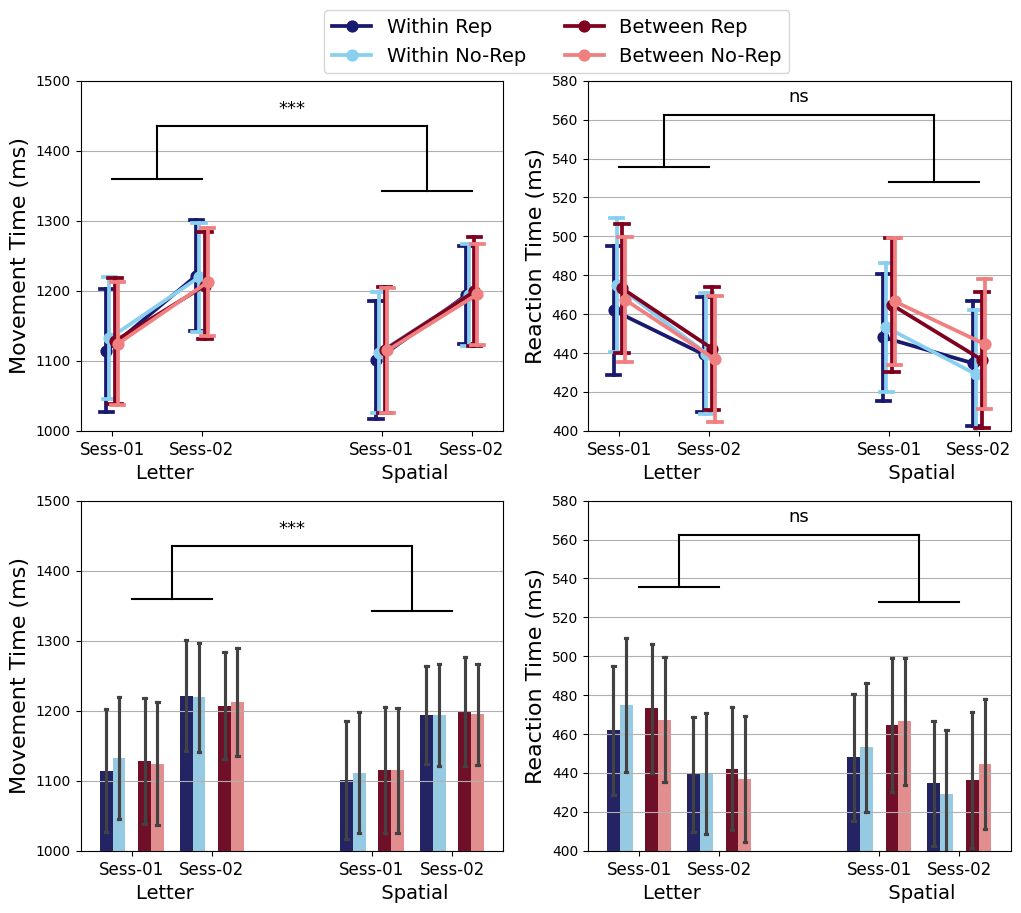

In [19]:
color = 'black'
for aa in range(2):
    for ii, value in enumerate(['MT','RT']):
        ax = axs[aa,ii]
        ## t-test
        a = tmp[tmp.cue=='L'][value].astype(float)
        b = tmp[tmp.cue=='S'][value].astype(float)
        res = scipy.stats.ttest_rel(a,b,alternative='greater')
        tval = res.statistic
        pval = res.pvalue
        print('%s: t(%d)=%.4f (%s)'%(value, res.df, res.statistic, sstat.convert_pval_to_star(res.pvalue)))
        
        ylim = np.array(ax.get_ylim())
        ydiff = np.diff(ylim)[0]
        ymean = ylim.mean()
        dy = ydiff * 0.05
        # ax.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
        
        x1 = 0.5
        y1 = a.mean() + a.sem() + dy*4
        ax.plot([0,1],[y1,y1],linestyle='-',color=color)
        x2 = 3.5
        y2 = b.mean() + b.sem() + dy*4
        ax.plot([3,4],[y2,y2],linestyle='-',color=color)
        yU = max(y1,y2) + dy*3
        ax.plot([x1,x1],[y1,yU],linestyle='-',color=color)
        ax.plot([x2,x2],[y2,yU],linestyle='-',color=color)
        ax.plot([x1,x2],[yU,yU],linestyle='-',color=color)
        ax.text(
            (x1+x2)*0.5, yU+dy,
            sstat.convert_pval_to_star(pval), fontsize=13, color=color,
            ha='center', va='center'
        )
fig

#### ii) Differences across session

In [20]:
tmp = dg.groupby(['subj','sess'])[['isError','MT','RT']].mean().reset_index()
tmp

,subj,sess,isError,MT,RT
0,01,R,0.047917,1463.066667,350.837500
1,01,S,0.060417,1783.070833,411.954167
2,02,R,0.010417,1235.854167,365.937500
3,02,S,0.008333,1030.395833,374.012500
4,03,R,0.018750,1223.720833,416.445833
5,03,S,0.022917,1042.945833,441.758333
6,05,R,0.004167,1327.291667,428.112500
7,05,S,0.020833,1094.920833,425.166667
8,06,R,0.002083,1312.808333,678.241667
9,06,S,0.027083,1050.216667,735.045833


t(11)=2.5109 (*)


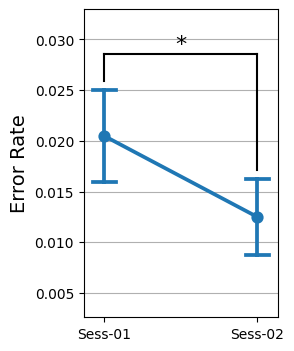

In [21]:
_, ax = plt.subplots(figsize=(2.5,4))
g = sns.pointplot(
    data = tmp,
    x = 'sess', order=['S','R'],
    y='isError',
    errorbar='se', capsize=0.15
)
g.grid(axis='y')
g.set_xlabel('')
g.set_ylabel('Error Rate', fontsize=14)
g.set_xticks([0,1])
g.set_xticklabels(['Sess-01','Sess-02'])

## t-test
a = tmp[tmp.sess=='S']['isError'].astype(float)
b = tmp[tmp.sess=='R']['isError'].astype(float)
res = scipy.stats.ttest_rel(a,b,alternative='greater')
tval = res.statistic
pval = res.pvalue
print('t(%d)=%.4f (%s)'%(res.df, tval, sstat.convert_pval_to_star(pval)))

ylim = np.array(g.get_ylim())
ydiff = np.diff(ylim)[0]
ymean = ylim.mean()
dy = ydiff * 0.05
g.set_ylim([ymean-ydiff*0.8, ymean+ydiff*0.9])
if pval < 0.05:
    x1 = 0
    x2 = 1
    y1 = a.mean() + a.sem() + dy
    y2 = b.mean() + b.sem() + dy
    yU = max(y1,y2) + dy*3
    color = 'black'
    g.plot([x1,x1],[y1,yU],linestyle='-',color=color)
    g.plot([x2,x2],[y2,yU],linestyle='-',color=color)
    g.plot([x1,x2],[yU,yU],linestyle='-',color=color)
    g.text(
        (x1+x2)*0.5, yU+dy,
        sstat.convert_pval_to_star(pval), fontsize=16, color=color,
        ha='center', va='center'
    )

#### iii) Repetition advaantage in MT and RT

In [22]:
tmp = dg[dg.isError==0].groupby(['subj','sess','cond','cue'])[['MT','RT']].mean().reset_index()
tmp

,subj,sess,cond,cue,MT,RT
0,01,R,Both-Rep,L,1485.250000,368.687500
1,01,R,Both-Rep,S,1368.250000,322.250000
2,01,R,Cue-Rep,L,1525.670588,373.341176
3,01,R,Cue-Rep,S,1414.048780,318.073171
4,01,R,Non-Rep,L,1481.166667,359.904762
...,...,...,...,...,...,...
187,14,S,Cue-Rep,S,955.617978,334.584270
188,14,S,Non-Rep,L,983.126437,368.252874
189,14,S,Non-Rep,S,955.372093,334.395349
190,14,S,Seq-Rep,L,1000.148148,358.592593


In [23]:
for ii, sess in enumerate(['S','R']):
    print('sess %s'%sess)
    for jj, cue in enumerate(['L','S']):
        print('cue %s'%cue)
        for kk, value in enumerate(['MT','RT']):
            ## t-test
            a = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Both-Rep')][value].astype(float)
            b = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Cue-Rep')][value].astype(float)
            res = scipy.stats.ttest_rel(a,b,alternative='less')
            tval = res.statistic
            pval = res.pvalue
            print('%s (%s): t(%d)=%.4f (%s)'%('B vs. C', value, res.df, tval, sstat.convert_pval_to_star(pval)))
    
            a = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Seq-Rep')][value].astype(float)
            b = tmp[(tmp.sess==sess)&(tmp.cue==cue)&(tmp.cond=='Non-Rep')][value].astype(float)
            res = scipy.stats.ttest_rel(a,b,alternative='less')
            tval = res.statistic
            pval = res.pvalue
            print('%s (%s): t(%d)=%.4f (%s)'%('S vs. N', value, res.df, tval, sstat.convert_pval_to_star(pval)))
        print('')

sess S
cue L
B vs. C (MT): t(11)=-0.8058 (ns)
S vs. N (MT): t(11)=0.3149 (ns)
B vs. C (RT): t(11)=-0.9585 (ns)
S vs. N (RT): t(11)=1.3320 (ns)

cue S
B vs. C (MT): t(11)=-0.0288 (ns)
S vs. N (MT): t(11)=-0.3418 (ns)
B vs. C (RT): t(11)=-0.9747 (ns)
S vs. N (RT): t(11)=-0.4148 (ns)

sess R
cue L
B vs. C (MT): t(11)=-1.0506 (ns)
S vs. N (MT): t(11)=-0.8248 (ns)
B vs. C (RT): t(11)=0.4203 (ns)
S vs. N (RT): t(11)=0.7853 (ns)

cue S
B vs. C (MT): t(11)=0.3834 (ns)
S vs. N (MT): t(11)=-0.1857 (ns)
B vs. C (RT): t(11)=0.4286 (ns)
S vs. N (RT): t(11)=-2.0063 (*)



---
---

In [30]:
# fig.savefig(
#     join(dir_work,'results/fig.behav.Rep.barplot.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

### 왜 session R에서 MT가 더 높은가?
- 단순히 더 정확히 하기 위해서 느려진 것이 아닌가?

In [18]:
palette = ['#4a83d1','#d1984a']

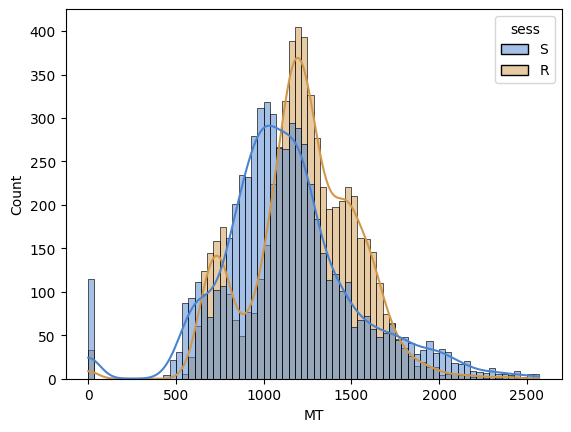

In [19]:
g = sns.histplot(
    data=dg,
    x='MT',
    hue='sess', palette=palette, kde=True,
    alpha=0.5
)
# g.legend()

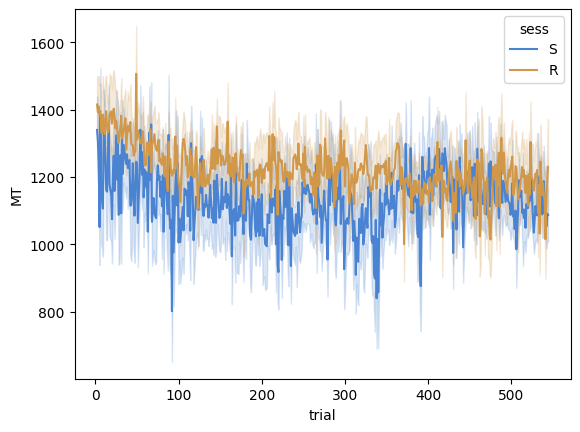

In [20]:
g = sns.lineplot(
    data=dg,
    x='trial', y='MT',
    hue='sess', palette=palette,
    errorbar='se', err_style='band'
)

-> 실험 초반에 느리게 함. 정확성을 위해서가 맞는 듯.

---